<a href="https://www.kaggle.com/code/sentienttrapezoid/pg-s4ep10-loan-status-basic-eda-model-comparisons?scriptVersionId=199791789" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


<h2>Libraries</h2>

In [2]:
import warnings
import time
from sklearn.exceptions import ConvergenceWarning

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve, auc

<h2>EDA</h2>

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


<h3>Target distribution</h3>

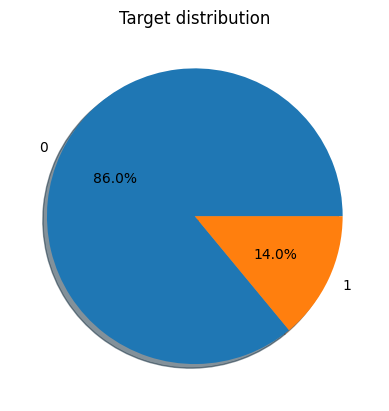

In [5]:
train_target_perc = (train_df['loan_status'].value_counts()/len(train_df)).round(2)

fig, axes = plt.subplots(1,1)
axes.pie(train_target_perc.values, labels = train_target_perc.index, 
                autopct='%1.1f%%', shadow=True)
axes.set_title('Target distribution')

plt.show()


The target distribution is imbalance, this suggests the use of balancing techniques (under-sampling/over-sampling/SMOTE) in future version of this notebook.

<h3>Missing Values</h3>

In [6]:
def nan_finder(data):
    nan_df = (100 * data.isnull().sum() / len(data)).round(2)
    nan_df.name = 'nan values(%)'
    return nan_df
nan_finder(train_df)

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
Name: nan values(%), dtype: float64

In [7]:
nan_finder(test_df)

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
Name: nan values(%), dtype: float64

Both the training and testing dataset have no missing values, therefore imputing is not needed.

<h3>Categorical/Numerical features</h3>

In [8]:
train_df.nunique().sort_values()

cb_person_default_on_file        2
loan_status                      2
person_home_ownership            4
loan_intent                      6
loan_grade                       7
cb_person_cred_hist_length      29
person_emp_length               36
person_age                      53
loan_percent_income             61
loan_int_rate                  362
loan_amnt                      545
person_income                 2641
dtype: int64

In [9]:
X = train_df.copy()
X.drop(['loan_status'], axis=1, inplace=True)
y = train_df['loan_status']
X_test = test_df.copy()
cat_cols = [cname for cname in X.columns if X[cname].dtype == 'object' and X[cname].nunique() < 10]
num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64'] and X[cname].nunique() > 10]
print('categorical columns:\n', cat_cols)
print('numerical columns:\n', num_cols)

categorical columns:
 ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical columns:
 ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


There are 4 categorical features and 7 numerical features.

<h3>Features correlation</h3>

We first produce the correlation matrix:

<Axes: >

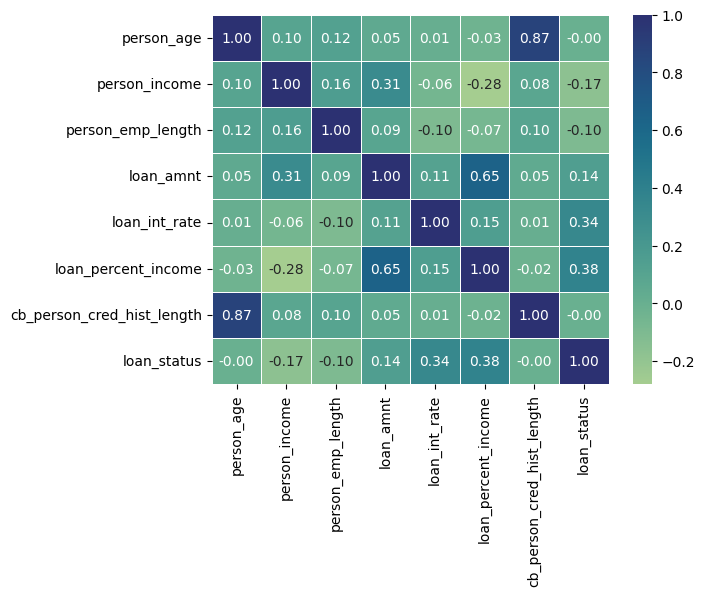

In [10]:
corr_matrix = train_df[num_cols + ['loan_status']].corr()
sns.heatmap(corr_matrix, annot=True, fmt = ".2f", cmap="crest", linewidth=0.5)

The target (loan_status) have a mild correlation with loan_percent_income, loan_int_rate and person_income.

In [11]:
X_mut = X.copy()

for cname in X_mut.select_dtypes(include='object'):
    X_mut[cname],_ = X_mut[cname].factorize()

discrete_features = X_mut.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features)
    mi_series = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_series = mi_series.sort_values(ascending=False)
    return mi_series

mi_scores = make_mi_scores(X_mut, y , discrete_features=discrete_features)
mi_scores 

person_income                 0.121379
loan_int_rate                 0.083384
loan_percent_income           0.080825
loan_grade                    0.078325
person_home_ownership         0.032372
loan_amnt                     0.020381
cb_person_default_on_file     0.014674
person_emp_length             0.008798
loan_intent                   0.005720
person_age                    0.001255
cb_person_cred_hist_length    0.000572
Name: MI Scores, dtype: float64

We study the train and test feature distributions for both numerical and categorical features, together with the target distribution:

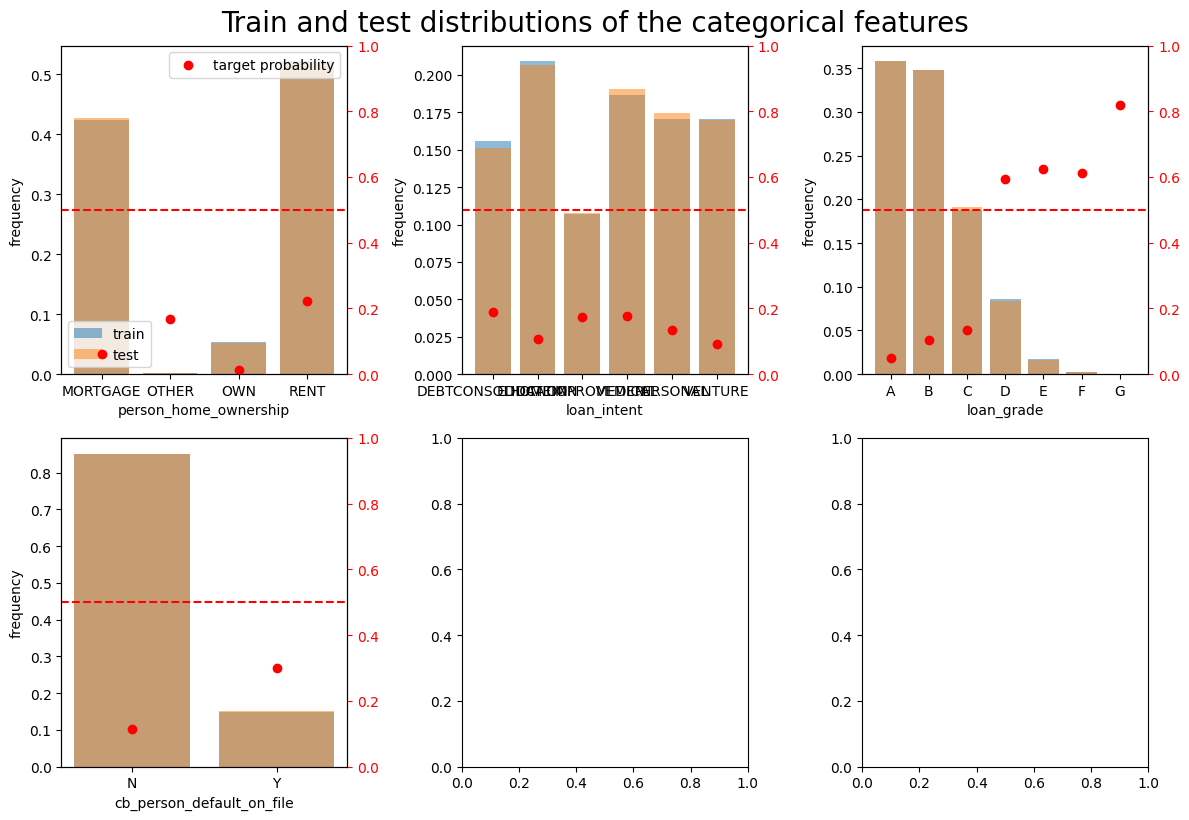

In [12]:

def cat_distr_plot(train, test, cols, target):
    rows = int(np.ceil(len(cols)/3))
    _, axes = plt.subplots(rows,3, figsize=(12,8))
    for f, ax in zip(cols, axes.ravel()):
        train_gb = train[target].groupby(train[f]).agg(['mean', 'size'])
        ax.bar(train_gb.index, train_gb['size'] / len(train), alpha=0.5, label='train')
        test_gb = test[f].value_counts()
        ax.bar(test_gb.index, test_gb / len(test), alpha=0.5, label='test')
        ax.set_xlabel(f)
        if ax == axes.flat[0] : ax.legend(loc='lower left')
        ax.set_ylabel('frequency')
        ax2 = ax.twinx()
        ax2.scatter(train_gb.index, train_gb['mean'], color='r', label='target probability')
        ax2.axhline(y=0.5, color='r', linestyle='--')
        ax2.set_ylim(0., 1.)
        ax2.tick_params(axis='y', colors='r')
        if ax == axes.flat[0] : ax2.legend(loc='upper right')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the categorical features', fontsize=20, y=1.02)
    plt.show()
    del train_gb, test_gb

cat_distr_plot(train_df, X_test, cat_cols, 'loan_status')

**Insight:**
<ul>
    <li>The training and testing datasets have similar distribution.</li>
    <li>The loan grade is correlated with the target.</li>
</ul>

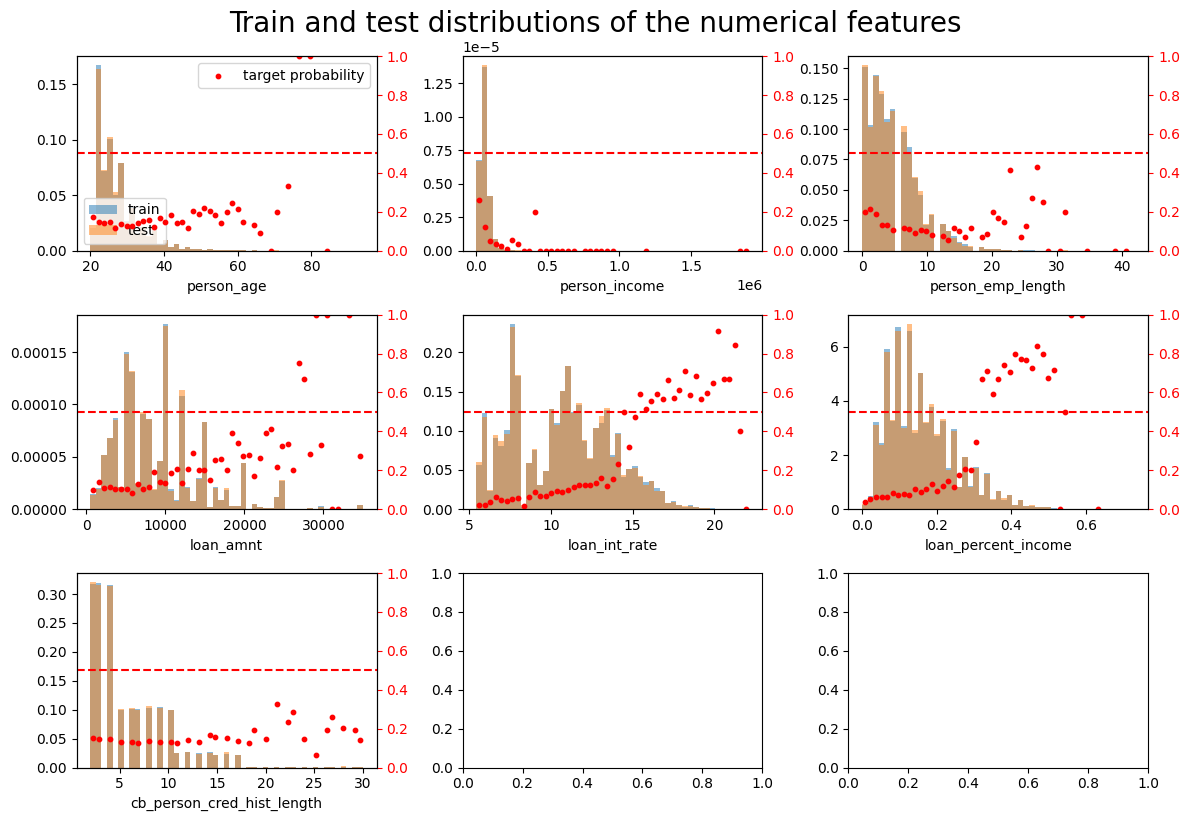

In [13]:

def num_distr_plot(train, test, cols, target):
    rows = int(np.ceil(len(cols)/3))
    _, axes = plt.subplots(rows,3, figsize=(12,8))
    for col, ax in zip(cols, axes.ravel()):
        min_v = min(train[col].min(), test[col].min())
        max_v = min(train[col].max(), test[col].max())
        bins = np.linspace(min_v, max_v, 50)
        ax.hist(train[col], bins=bins, alpha=0.5, density=True, label='train')
        ax.hist(test[col], bins=bins, alpha=0.5, density=True, label='test')
        if ax == axes.flat[0] : ax.legend(loc='lower left')
        ax.set_xlabel(col)
        ax2 = ax.twinx()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=RuntimeWarning)
            total, _ = np.histogram(train[col], bins=bins)
            tar_val, _ = np.histogram(train[col][target==1], bins=bins)
            ax2.scatter((bins[1:] + bins[:-1]) / 2, tar_val / total, color='r', s = 10, label='target probability')
            ax2.axhline(y=0.5, color='r', linestyle='--')
            ax2.set_ylim(0., 1.)
            ax2.tick_params(axis='y', colors='r')
            if ax == axes.flat[0] : ax2.legend(loc='upper right')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the numerical features', fontsize=20, y=1.02)
    plt.show()
    
num_distr_plot(X, X_test, num_cols, y)

**Insight:**
<ul>
    <li>Most features are skewed and would benefit from a log-tranformation.</li>
    <li>Both the loan interest rate and percent income are significantly correlated with the target.</li>
</ul>

<h2>Feature engineering</h2>

For this first approached we merely log-transform the more relevant numerical features:

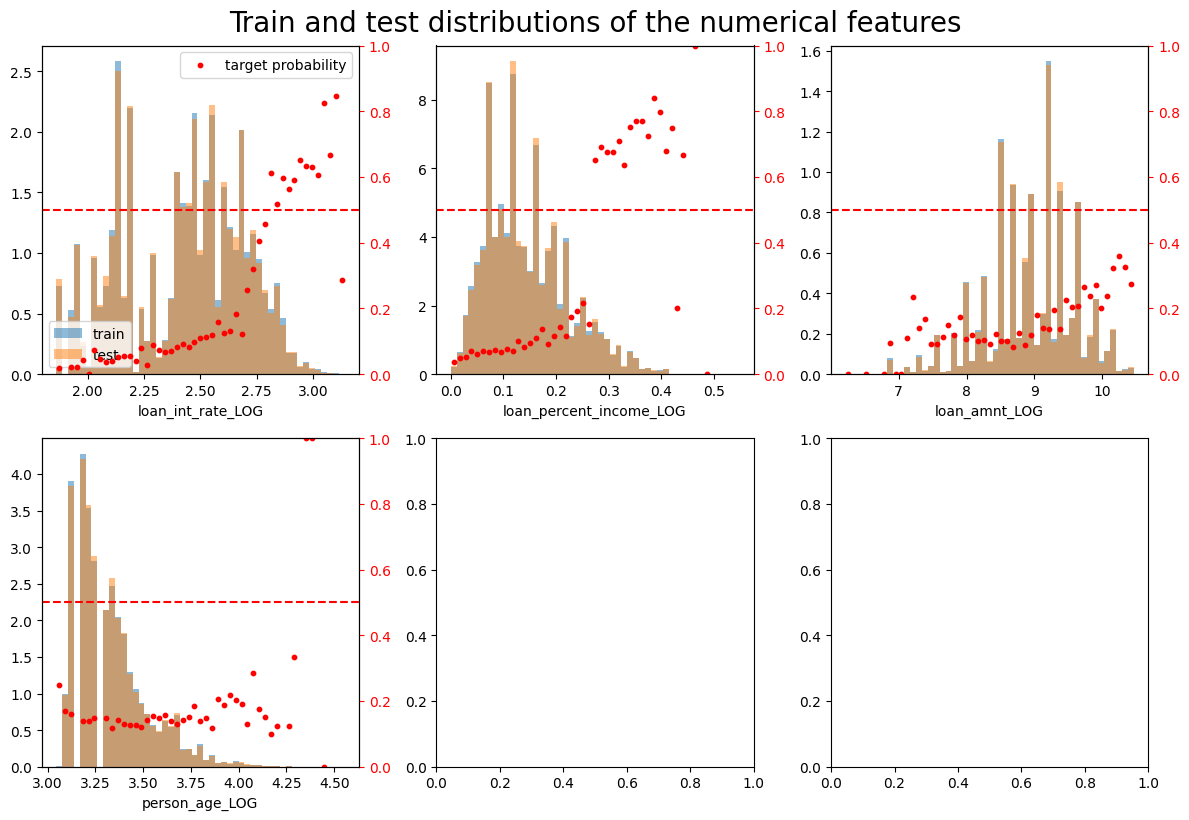

In [14]:
for col in ['loan_int_rate', 'loan_percent_income', 'loan_amnt', 'person_age']:
    X[col + '_LOG'] = np.log(1 + X[col])
    X_test[col + '_LOG'] = np.log(1 + X_test[col])
log_cols = ['loan_int_rate_LOG', 'loan_percent_income_LOG', 'loan_amnt_LOG', 'person_age_LOG']
num_distr_plot(X, X_test, log_cols, y)

<h2>Preprocessing</h2>

For the models' training we use the loan grade as categorical features and the interest rate, percent income and loan amount as numerical features, the first is One Hot Encoded while the latter are scaled (not necessary for the following models, but might be useful in future applications)

In [15]:
cat_feats = ['loan_grade']
num_feats = ['loan_int_rate_LOG', 'loan_percent_income_LOG', 'loan_amnt_LOG']
train_feats = cat_feats + num_feats


cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False)),
])

num_pipeline = Pipeline([
    ('scale', MinMaxScaler()),
])

prep_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, cat_feats),
    ('num', num_pipeline, num_feats),
])

<h2>Models comparisons</h2>

We perform a Grid Search on three models:
<ul>
    <li>K-neighbors Classifier</li>
    <li>Random Forest Regressor</li>
    <li>Light Gradient Boosting Machine</li>
</ul>
the model are then compared according to the area under the ROC curve produced on a (single) validation set (selected using stratification due to the umbalanced nature of the target).

In [16]:

X_train, X_valid, y_train, y_valid = train_test_split(X[train_feats], y, stratify=y, test_size=0.2, random_state=0)

model_dict = {
'KNC' : KNeighborsClassifier(),
'RF' : RandomForestRegressor(random_state=0),
"LGBM" : LGBMClassifier(random_state=0, verbosity=-1)
}

LR_params = {'model__penalty': ['l1','l2'],
           'model__C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'model__max_iter': [50, 100, 150]}

KNC_params = {'model__n_neighbors': [3, 5, 7, 9],
            'model__p': [1, 2]}


RF_params = {'model__n_estimators': [50, 100],
        'model__max_depth': [4, 6, 8, 10, 12]}

LGBM_params = {'model__n_estimators': [50, 100, 150, 200],
        'model__max_depth': [4, 8, 12],
        'model__learning_rate': [0.05, 0.1, 0.15]}

grid_params = {
    'KNC' : KNC_params,
    'RF' : RF_params,
    'LGBM' : LGBM_params
}

In [17]:

i=0
model_best_params=model_dict.copy()
grid_results=pd.DataFrame({'Model':model_dict.keys(), #'Precision': np.zeros(len(model_dict)), 'Recall': np.zeros(len(model_dict)),
                           'AUC': np.zeros(len(model_dict)), 'Training time': np.zeros(len(model_dict))})
for key, model in model_dict.items():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        print(model)
        full_pipeline = Pipeline([
            ('preprocessor', prep_pipeline),
            ('model', model),
            ])
        start = time.time()
        model_gscv = GridSearchCV(estimator=full_pipeline, param_grid=grid_params[key], n_jobs=-1, cv=None)

        model_gscv.fit(X_train, y_train)
        y_preds = model_gscv.predict(X_valid)
        fpr, tpr, _ = roc_curve(y_valid, y_preds)
        auc_v = auc(fpr, tpr)
        grid_results.iloc[i,1] = auc_v
        model_best_params[key]=model_gscv.best_params_

        stop = time.time()
        grid_results.iloc[i,2]=np.round((stop - start), 2)

        print('Model:', key)
        print('Training time (s):', grid_results.iloc[i,2])
        print('')
        i+=1

KNeighborsClassifier()
Model: KNC
Training time (s): 21.2

RandomForestRegressor(random_state=0)
Model: RF
Training time (s): 55.67

LGBMClassifier(random_state=0, verbosity=-1)
Model: LGBM
Training time (s): 101.45



In [18]:
grid_results

,Model,AUC,Training time
0,KNC,0.765704,21.20
1,RF,0.898146,55.67
2,LGBM,0.785320,101.45


The Random Forest Regressor performed best.

<h2>Model prediction</h2>

We first extract the best parameters from the previous analysis:

In [19]:
model_best_params

{'KNC': {'model__n_neighbors': 9, 'model__p': 1},
 'RF': {'model__max_depth': 8, 'model__n_estimators': 100},
 'LGBM': {'model__learning_rate': 0.05,
  'model__max_depth': 8,
  'model__n_estimators': 200}}

and use it to fit the model on the whole training set and then perform the predictions.

In [20]:
best_model = RandomForestRegressor(n_estimators = 100, max_depth = 8)
best_pipeline = Pipeline([
        ('preprocessor', prep_pipeline),
        ('model', best_model),
        ])
best_pipeline.fit(X[train_feats], y)
y_preds = best_pipeline.predict(X_test)

Finally we submit the prediction:

In [21]:
submission_df = pd.DataFrame({'id': np.arange(58645, 58645 + len(y_preds),1), 'loan_status': y_preds})
submission_df.to_csv('submission1.csv', index=False)

The auc value obtained with this setup is 0.90431.